# Summer of Code - Artificial Intelligence

## Week 10: Deep Learning

### Day 02: Long Short Term Memory (LSTM)

In this notebook, we will learn the theoretical foundations of **Long Short Term Memory (LSTM)** networks using PyTorch.


# Problems with RNNs
RNNs face two main challenges:
1. **Exploding Gradients**: During backpropagation, gradients can become very large.
2. **Short-Term Memory**: RNNs struggle to retain information over long sequences.

# Long Short-Term Memory (LSTM) Cells
LSTMs are enhanced RNNs designed to address these challenges. They introduce a memory cell and gating mechanisms to control information flow. LSTM cells has two main components:
1. **State**: The memory that retains information over time, which includes:
   - **Cell State**: The long-term memory that carries information across time steps.
   - **Hidden State**: The short-term memory that captures information at the current time step.
2. **Gates**: Mechanisms that regulate the flow of information into and out of the state.

<img src="images/lstm.png" width="600"/>

# Gated Recurrent Unit (GRU) Cell
GRUs are a simplified version of LSTMs that combine the forget and input gates into a single update gate. It combines the cell state and hidden state into a single state, reducing complexity while maintaining performance.

<img src="images/gru.png" width="600"/>

# Sentiment Analysis

A sequence to vector problem


## IMDB Dataset

This dataset contains 50,000 movie reviews labeled as positive or negative.


In [2]:
from datasets import load_dataset

# Load IMDB dataset
print("Loading IMDB dataset...")
dataset = load_dataset("imdb")
dataset

Loading IMDB dataset...


DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

In [3]:
dataset['train']

Dataset({
    features: ['text', 'label'],
    num_rows: 25000
})

In [4]:
dataset['train'][1]

{'text': '"I Am Curious: Yellow" is a risible and pretentious steaming pile. It doesn\'t matter what one\'s political views are because this film can hardly be taken seriously on any level. As for the claim that frontal male nudity is an automatic NC-17, that isn\'t true. I\'ve seen R-rated films with male nudity. Granted, they only offer some fleeting views, but where are the R-rated films with gaping vulvas and flapping labia? Nowhere, because they don\'t exist. The same goes for those crappy cable shows: schlongs swinging in the breeze but not a clitoris in sight. And those pretentious indie movies like The Brown Bunny, in which we\'re treated to the site of Vincent Gallo\'s throbbing johnson, but not a trace of pink visible on Chloe Sevigny. Before crying (or implying) "double-standard" in matters of nudity, the mentally obtuse should take into account one unavoidably obvious anatomical difference between men and women: there are no genitals on display when actresses appears nude, 

In [6]:
# Extract train and test data
train_data = [(item["label"], item["text"]) for item in dataset["train"]]
test_data = [(item["label"], item["text"]) for item in dataset["test"]]
print(f"Training samples: {len(train_data)}")
print(f"Test samples: {len(test_data)}")

Training samples: 25000
Test samples: 25000


In [7]:
test_data[0]

(0,
 'I love sci-fi and am willing to put up with a lot. Sci-fi movies/TV are usually underfunded, under-appreciated and misunderstood. I tried to like this, I really did, but it is to good TV sci-fi as Babylon 5 is to Star Trek (the original). Silly prosthetics, cheap cardboard sets, stilted dialogues, CG that doesn\'t match the background, and painfully one-dimensional characters cannot be overcome with a \'sci-fi\' setting. (I\'m sure there are those of you out there who think Babylon 5 is good sci-fi TV. It\'s not. It\'s clichéd and uninspiring.) While US viewers might like emotion and character development, sci-fi is a genre that does not take itself seriously (cf. Star Trek). It may treat important issues, yet not as a serious philosophy. It\'s really difficult to care about the characters here as they are not simply foolish, just missing a spark of life. Their actions and reactions are wooden and predictable, often painful to watch. The makers of Earth KNOW it\'s rubbish as they

## Preprocessing

Before feeding text into our RNN, we need to preprocess it:

1. **Lowercase**: Convert all text to lowercase for consistency
2. **Remove special characters**: Keep only alphabetic characters and spaces
3. **Tokenization**: Split text into individual words (tokens)

In [8]:
import re

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    tokens = text.split()  # Simple tokenization
    return tokens

In [9]:

# Test preprocessing
sample_text = train_data[0][1]

tokens = preprocess_text(sample_text)
print(f"Original text: {sample_text[:100]}...")
print(f"\nTokens (first 20): {tokens[:20]}")
print(f"Total tokens: {len(tokens)}")

Original text: I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it w...

Tokens (first 20): ['i', 'rented', 'i', 'am', 'curiousyellow', 'from', 'my', 'video', 'store', 'because', 'of', 'all', 'the', 'controversy', 'that', 'surrounded', 'it', 'when', 'it', 'was']
Total tokens: 288


## Build Vocabulary

A vocabulary is a mapping from words to unique integer indices. Neural networks work with numbers, not words, so we need to convert each word to a unique number.

We'll build our vocabulary from the training data and include special tokens:

- `<PAD>`: Padding token (index 0) - used to make all sequences the same length
- `<UNK>`: Unknown token (index 1) - used for words not in our vocabulary


In [10]:
from collections import Counter


def build_vocabulary(data, max_vocab_size=1000):
    word_counts = Counter()
    for i, (label, text) in enumerate(data):
        tokens = preprocess_text(text)
        word_counts.update(tokens)

    most_common = word_counts.most_common(max_vocab_size - 2)

    # Create vocabulary with special tokens
    vocab = {"<PAD>": 0, "<UNK>": 1}

    # Add most common words
    for word, _ in most_common:
        vocab[word] = len(vocab)

    return vocab, word_counts


# Build vocabulary from training data
vocab, word_counts = build_vocabulary(train_data, max_vocab_size=1000)
print(f"Vocabulary size: {len(vocab)}")
print(f"\nFirst 10 words in vocabulary:")
for word, idx in list(vocab.items())[:10]:
    print(f"  {word}: {idx}")

print(f"\nMost common words:")
for word, count in word_counts.most_common(10):
    print(f"  {word}: {count}")

Vocabulary size: 1000

First 10 words in vocabulary:
  <PAD>: 0
  <UNK>: 1
  the: 2
  and: 3
  a: 4
  of: 5
  to: 6
  is: 7
  in: 8
  it: 9

Most common words:
  the: 334706
  and: 162227
  a: 161941
  of: 145326
  to: 135042
  is: 106852
  in: 93028
  it: 77101
  i: 75717
  this: 75190


## Text to Sequence Conversion

Convert text into sequences of integers using our vocabulary. Each word gets replaced by its index in the vocabulary.

We also need to handle sequences of different lengths by:

- **Truncating**: Cut sequences longer than max_length
- **Padding**: Add `<PAD>` tokens to sequences shorter than max_length

This ensures all sequences have the same length, which is required for batch processing.


In [11]:
def text_to_sequence(text, vocab, max_length=200):
    tokens = preprocess_text(text)
    sequence = [vocab.get(token, vocab["<UNK>"]) for token in tokens]
    if len(sequence) > max_length:
        sequence = sequence[:max_length]
    else:
        sequence = sequence + [vocab["<PAD>"]] * (max_length - len(sequence))

    return sequence


# Test the conversion
sample_text = train_data[0][1]
sequence = text_to_sequence(sample_text, vocab, max_length=200)
print(f"Original text length: {len(preprocess_text(sample_text))} words")
print(f"Sequence length: {len(sequence)}")
print(f"First 20 indices: {sequence[:20]}")
print(f"Last 20 indices (should be padding): {sequence[-20:]}")

Original text length: 288 words
Sequence length: 200
First 20 indices: [10, 1, 10, 237, 1, 36, 56, 393, 1, 80, 5, 32, 2, 1, 12, 1, 9, 51, 9, 14]
Last 20 indices (should be padding): [1, 131, 56, 1, 348, 160, 9, 1, 8, 638, 392, 3, 1, 24, 4, 646, 1, 8, 1, 443]


## Custom Dataset Class

PyTorch's `Dataset` class provides a standard way to load and process data. We'll create a custom dataset that:

1. Stores our reviews and labels
2. Converts text to sequences when accessed
3. Returns tensors ready for training

In [14]:
import torch
from torch.utils.data import Dataset


class SentimentDataset(Dataset):
    """
    Custom Dataset for sentiment analysis.
    """

    def __init__(self, data, vocab, max_length=200):
        self.data = data
        self.vocab = vocab
        self.max_length = max_length

    def __len__(self):
        """Return the number of samples in the dataset."""
        return len(self.data)

    def __getitem__(self, idx):
        """
        Get a single sample.

        Returns:
            sequence (tensor): Input sequence of shape (max_length,)
            label (tensor): Label (0 or 1)
        """
        label, text = self.data[idx]

        # Convert text to sequence
        sequence = text_to_sequence(text, self.vocab, self.max_length)

        return torch.tensor(sequence, dtype=torch.long), torch.tensor(
            label, dtype=torch.long
        )


# Create datasets
train_dataset = SentimentDataset(train_data, vocab, max_length=200)
test_dataset = SentimentDataset(test_data, vocab, max_length=200)

print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")

# Test the dataset
sequence, label = train_dataset[0]
print(f"\nSample shape: {sequence.shape}")
print(f"Label: {label.item()} (0=negative, 1=positive)")

Training samples: 25000
Test samples: 25000

Sample shape: torch.Size([200])
Label: 0 (0=negative, 1=positive)


## DataLoaders

In [15]:
from torch.utils.data import DataLoader


# Hyperparameters
BATCH_SIZE = 32

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Number of training batches: {len(train_loader)}")
print(f"Number of test batches: {len(test_loader)}")

Number of training batches: 782
Number of test batches: 782


## RNN Model

Now we'll build our sentiment classifier using a simple RNN architecture. The model consists of:

1. **Embedding Layer**: Converts word indices to dense vectors
2. **RNN Layer**: Processes the sequence and captures temporal dependencies
3. **Fully Connected Layer**: Maps the RNN output to sentiment classes

In [16]:
from torch import nn


class SentimentLSTM(nn.Module):

    def __init__(
        self,
        vocab_size,
        embedding_dim,
        hidden_dim,
        output_dim,
        num_layers=1,
        dropout=0.5,
    ):
        super(SentimentLSTM, self).__init__()
        # Embedding with dropout
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.embedding_dropout = nn.Dropout(0.2)

        # LSTM layer
        self.lstm = nn.LSTM(
            embedding_dim,
            hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
        )

        pooling_dim = hidden_dim * 3  # last + mean + max

        # Deep output classifier with batch normalization
        self.classifier = nn.Sequential(
            nn.Linear(pooling_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.BatchNorm1d(hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout * 0.5),
            nn.Linear(hidden_dim // 2, output_dim),
        )

    def forward(self, x):
        # x shape: (batch_size, seq_length)

        # Embedding
        embedded = self.embedding(x)
        embedded = self.embedding_dropout(embedded)

        # LSTM forward pass
        output, (hidden, cell) = self.lstm(embedded)
        
        # Combine multiple pooling strategies
        last_pool = output[:, -1, :]
        mean_pool = torch.mean(output, dim=1)
        max_pool, _ = torch.max(output, dim=1)
        
        pooled = torch.cat([last_pool, mean_pool, max_pool], dim=1)

        # Deep classifier
        logits = self.classifier(pooled)

        return logits

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

VOCAB_SIZE = len(vocab)
EMBEDDING_DIM = 256      # Larger embeddings for richer representations
HIDDEN_DIM = 256         # Increased hidden dimension
OUTPUT_DIM = 2
NUM_LAYERS = 2           # Optimal number of layers for LSTM
DROPOUT = 0.5            # Moderate dropout

# Create LSTM model with advanced pooling
model = SentimentLSTM(
    vocab_size=VOCAB_SIZE,
    embedding_dim=EMBEDDING_DIM,
    hidden_dim=HIDDEN_DIM,
    output_dim=OUTPUT_DIM,
    num_layers=NUM_LAYERS,
    dropout=DROPOUT,
)
model = model.to(device)

print(f"Model: LSTM-based Sentiment Classifier with Advanced Pooling")
print(f"Configuration:")
print(f"  - Embedding Dim: {EMBEDDING_DIM}")
print(f"  - Hidden Dim: {HIDDEN_DIM}")
print(f"  - Num Layers: {NUM_LAYERS}")
print(f"  - Dropout: {DROPOUT}")
print(f"  - Device: {device}")

Model: LSTM-based Sentiment Classifier with Advanced Pooling
Configuration:
  - Embedding Dim: 256
  - Hidden Dim: 256
  - Num Layers: 2
  - Dropout: 0.5
  - Device: cuda


In [18]:
from torchinfo import summary

input_sample = torch.zeros(BATCH_SIZE, 200, dtype=torch.long).to(device)
summary(model, input_data=input_sample)

Layer (type:depth-idx)                   Output Shape              Param #
SentimentLSTM                            [32, 2]                   --
├─Embedding: 1-1                         [32, 200, 256]            256,000
├─Dropout: 1-2                           [32, 200, 256]            --
├─LSTM: 1-3                              [32, 200, 256]            1,052,672
├─Sequential: 1-4                        [32, 2]                   --
│    └─Linear: 2-1                       [32, 256]                 196,864
│    └─BatchNorm1d: 2-2                  [32, 256]                 512
│    └─ReLU: 2-3                         [32, 256]                 --
│    └─Dropout: 2-4                      [32, 256]                 --
│    └─Linear: 2-5                       [32, 128]                 32,896
│    └─BatchNorm1d: 2-6                  [32, 128]                 256
│    └─ReLU: 2-7                         [32, 128]                 --
│    └─Dropout: 2-8                      [32, 128]            

## Loss Function and Optimizer

In [ ]:
from torch import optim

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer - Higher learning rate for faster initial learning
LEARNING_RATE = 0.001  # Increased from 0.001
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=0.00001)

# Learning rate scheduler for better convergence
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode="min",
    factor=0.5,
    patience=1,  # Reduced patience for faster adaptation
)

print(f"Optimizer: Adam (lr={LEARNING_RATE}, weight_decay=1e-5)")
print(f"Scheduler: ReduceLROnPlateau (factor=0.5, patience=1)")

Optimizer: Adam (lr=0.001, weight_decay=1e-5)
Scheduler: ReduceLROnPlateau (factor=0.5, patience=1)


## Train Epoch

In [20]:
def train_epoch(model, dataloader, criterion, optimizer, device, clip_grad=1.0):
    model.train()  # Set model to training mode

    total_loss = 0
    correct = 0
    total = 0

    for batch_idx, (sequences, labels) in enumerate(dataloader):
        sequences = sequences.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(sequences)
        loss = criterion(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()

        # Gradient clipping to prevent exploding gradients
        if clip_grad > 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_grad)

        optimizer.step()

        # Track statistics
        total_loss += loss.item()
        predictions = outputs.argmax(dim=1)
        correct += (predictions == labels).sum().item()
        total += labels.size(0)
    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total

    return avg_loss, accuracy

## Evaluation Function


In [21]:
def evaluate(model, dataloader, criterion, device):
    model.eval()

    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for sequences, labels in dataloader:
            sequences = sequences.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(sequences)

            # Calculate loss
            loss = criterion(outputs, labels)

            # Track statistics
            total_loss += loss.item()
            predictions = outputs.argmax(dim=1)
            correct += (predictions == labels).sum().item()
            total += labels.size(0)

    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total

    return avg_loss, accuracy

## Train the Model


In [23]:
# Training parameters
NUM_EPOCHS = 10  # Increased epochs for better convergence
CLIP_GRAD = 1.0  # Gradient clipping threshold

# Track metrics
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []
best_test_acc = 0

print("Starting training...")
print("=" * 60)

for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch + 1}/{NUM_EPOCHS}")
    print("-" * 60)

    # Train
    train_loss, train_acc = train_epoch(
        model, train_loader, criterion, optimizer, device, clip_grad=CLIP_GRAD
    )

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Evaluate
    test_loss, test_acc = evaluate(model, test_loader, criterion, device)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

    # Learning rate scheduling
    scheduler.step(test_loss)

    # Track best model
    if test_acc > best_test_acc:
        best_test_acc = test_acc
        print(f"  New best test accuracy: {best_test_acc:.4f}")

    # Print epoch summary
    print(f"\n  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"  Test Loss:  {test_loss:.4f}, Test Acc:  {test_acc:.4f}")
    print(f"  Current LR: {optimizer.param_groups[0]['lr']:.6f}")

print("\n" + "=" * 60)
print("Training completed!")
print(f"Best Test Accuracy: {best_test_acc:.4f}")

Starting training...

Epoch 1/10
------------------------------------------------------------
  New best test accuracy: 0.8355

  Train Loss: 0.4920, Train Acc: 0.7530
  Test Loss:  0.3627, Test Acc:  0.8355
  Current LR: 0.001000

Epoch 2/10
------------------------------------------------------------
  New best test accuracy: 0.8446

  Train Loss: 0.3711, Train Acc: 0.8366
  Test Loss:  0.3473, Test Acc:  0.8446
  Current LR: 0.001000

Epoch 3/10
------------------------------------------------------------
  New best test accuracy: 0.8605

  Train Loss: 0.3299, Train Acc: 0.8562
  Test Loss:  0.3178, Test Acc:  0.8605
  Current LR: 0.001000

Epoch 4/10
------------------------------------------------------------

  Train Loss: 0.2975, Train Acc: 0.8728
  Test Loss:  0.3234, Test Acc:  0.8590
  Current LR: 0.001000

Epoch 5/10
------------------------------------------------------------

  Train Loss: 0.2643, Train Acc: 0.8895
  Test Loss:  0.3327, Test Acc:  0.8588
  Current LR: 0.00

## Visualize Training Progress

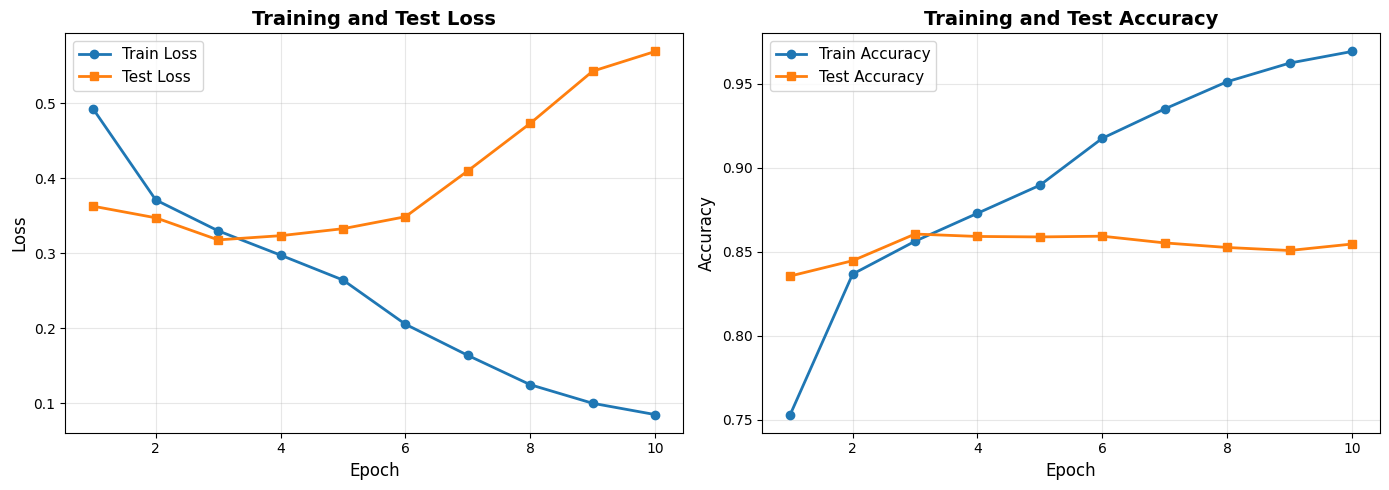

Final Train Accuracy: 0.9692
Final Test Accuracy: 0.8545


In [25]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot loss
axes[0].plot(
    range(1, NUM_EPOCHS + 1), train_losses, marker="o", label="Train Loss", linewidth=2
)
axes[0].plot(
    range(1, NUM_EPOCHS + 1), test_losses, marker="s", label="Test Loss", linewidth=2
)
axes[0].set_xlabel("Epoch", fontsize=12)
axes[0].set_ylabel("Loss", fontsize=12)
axes[0].set_title("Training and Test Loss", fontsize=14, fontweight="bold")
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Plot accuracy
axes[1].plot(
    range(1, NUM_EPOCHS + 1),
    train_accuracies,
    marker="o",
    label="Train Accuracy",
    linewidth=2,
)
axes[1].plot(
    range(1, NUM_EPOCHS + 1),
    test_accuracies,
    marker="s",
    label="Test Accuracy",
    linewidth=2,
)
axes[1].set_xlabel("Epoch", fontsize=12)
axes[1].set_ylabel("Accuracy", fontsize=12)
axes[1].set_title("Training and Test Accuracy", fontsize=14, fontweight="bold")
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print final metrics
print(f"Final Train Accuracy: {train_accuracies[-1]:.4f}")
print(f"Final Test Accuracy: {test_accuracies[-1]:.4f}")

In [26]:
def predict_sentiment(model, text, vocab, device, max_length=200):
    model.eval()
    sequence = text_to_sequence(text, vocab, max_length)
    sequence_tensor = torch.tensor(sequence, dtype=torch.long).unsqueeze(0).to(device)

    # Make prediction
    with torch.no_grad():
        output = model(sequence_tensor)
        probabilities = torch.softmax(output, dim=1)
        prediction = output.argmax(dim=1).item()
        confidence = probabilities[0][prediction].item()

    sentiment = "Positive" if prediction == 1 else "Negative"

    return sentiment, confidence


# Test on custom reviews
test_reviews = [
    "This movie was absolutely fantastic! The acting was superb and the plot was engaging.",
    "Terrible movie. Waste of time and money. I would not recommend it to anyone.",
    "The film had its moments but overall it was quite disappointing.",
    "An absolute masterpiece! One of the best movies I've ever seen.",
    "Boring and predictable. I fell asleep halfway through.",
]

print("Custom Review Predictions:")
print("=" * 80)

for i, review in enumerate(test_reviews, 1):
    sentiment, confidence = predict_sentiment(model, review, vocab, device)
    print(f"\n{i}. Review: {review}")
    print(f"   Prediction: {sentiment} (Confidence: {confidence:.4f})")

Custom Review Predictions:

1. Review: This movie was absolutely fantastic! The acting was superb and the plot was engaging.
   Prediction: Positive (Confidence: 0.9999)

2. Review: Terrible movie. Waste of time and money. I would not recommend it to anyone.
   Prediction: Negative (Confidence: 1.0000)

3. Review: The film had its moments but overall it was quite disappointing.
   Prediction: Positive (Confidence: 0.9999)

4. Review: An absolute masterpiece! One of the best movies I've ever seen.
   Prediction: Positive (Confidence: 0.9994)

5. Review: Boring and predictable. I fell asleep halfway through.
   Prediction: Negative (Confidence: 0.9993)
